In [1]:
# !git clone https://github.com/YoojLee/paper_review

In [2]:
pwd

'/home/sh/lab/GAN'

In [3]:
%cd paper_review/code/cycle_gan

/home/sh/lab/GAN/paper_review/code/cycle_gan


# Train

In [ ]:
from sched import scheduler
import torch
from torch.utils.data import DataLoader

from augmentation import BaseAugmentation
from criterion import *
from dataset import UnalignedDataset
from model import *
from utils import *
from scheduler import DelayedLinearDecayLR

from functools import partial
import itertools
import os
from tqdm import tqdm
import wandb

# opt로 변경하는 작업
def train(opt):
    
    os.makedirs(opt.sample_save_dir, exist_ok=True)

    # device
    device = torch.device(f'cuda:{opt.gpu_id}' if torch.cuda.is_available() else 'cpu')    

    # define transforms
    transforms = BaseAugmentation()

    # load datasets
    train_data = UnalignedDataset(opt.data_root_A, opt.data_root_B, opt.is_train, transforms = transforms.transform)
    train_loader = DataLoader(train_data, batch_size=opt.batch_size, num_workers=opt.num_threads, shuffle=True)

    # load model
    G = Generator(init_channel=64, kernel_size=3, stride=2, n_blocks=9).to(device)
    F = Generator(init_channel=64, kernel_size=3, stride=2, n_blocks=9).to(device)
    D_x = Discriminator().to(device)
    D_y = Discriminator().to(device)

    # define optimizer
    optimizer = partial(torch.optim.Adam, lr=opt.lr, betas=(opt.beta1, 0.999))

    optim_G = optimizer(params = itertools.chain(G.parameters(), F.parameters()))
    optim_D = optimizer(params = itertools.chain(D_x.parameters(), D_y.parameters()))

    # scheduler
    scheduler_G = DelayedLinearDecayLR(optim_G, opt.lr, opt.target_lr, opt.total_iters, decay_after=opt.decay_after, verbose=opt.lr_decay_verbose)
    scheduler_D = DelayedLinearDecayLR(optim_D, opt.lr, opt.target_lr, opt.total_iters, decay_after=opt.decay_after, verbose=opt.lr_decay_verbose)


    criterion_G = AdversarialLoss()
    criterion_D = AdversarialLoss()
    criterion_cyc = CycleConsistencyLoss()
    criterion_idt = IdentityLoss()

    G.train()
    F.train()
    D_x.train()
    D_y.train()

    if opt.resume_from:
        checkpoint_path = os.path.join(opt.last_checkpoint_dir, f"epoch{opt.load_epoch}.pth")
        if "LinearDecay" in getattr(type(scheduler_D), '__name__'): # when using LinearDecayLR, not loading state dict for optimizers and schedulers.
            G, F, D_x, D_y, start_epoch = load_checkpoint(checkpoint_path, G, F, D_x, D_y)
            # decay after 같은 부분 수정하는 건 그냥 config 자체에서 받아오는 걸로 / last epoch만 수정해주자.
            scheduler_dict = {
                'decay_after': start_epoch + opt.decay_after,
                'last_epoch': opt.load_epoch
            }
            scheduler_G.load_state_dict(scheduler_dict)
            scheduler_D.load_state_dict(scheduler_dict)

        else:
            G, F, D_x, D_y, optim_G, optim_D, scheduler_G, scheduler_D, start_epoch = load_checkpoint(checkpoint_path, G, F, D_x, D_y, \
                                                                                                    optim_G, optim_D, scheduler_G, scheduler_D, mode="all")
        start_epoch += 1
    else: # not_resume from
        start_epoch = 0


    for epoch in range(start_epoch, start_epoch+opt.n_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, data in pbar:
            
            # Initialize the gradient stored in the optimizer to zero in the beginning of each step.
            optim_G.zero_grad()
            optim_D.zero_grad()

            # load data on gpu
            X, Y = data['A'].to(device), data['B'].to(device)

            #### Generator ####
            for p_x, p_y in zip(D_x.parameters(), D_y.parameters()): # when optimizing G, freeze the parameters regarding D.
                p_x.requires_grad = False
                p_y.requires_grad = False

            # generation & reconstruction
            g_x = G(X) # fake_B
            f_y = F(Y) # fake_A
            rec_x = F(g_x) # rec_A (reconstruction)
            rec_y = G(f_y) # rec_B
            
            # discriminating the generators' outputs.
            d_g_x = D_y(g_x)
            d_f_y = D_x(f_y)

            # generate the label
            real_label = torch.tensor([1.0]).expand_as(d_g_x).to(device)
            fake_label = torch.tensor([0.0]).expand_as(d_f_y).to(device)

            # calculate an adversarial loss -> maximize the probability of the fake to be "considered" real
            loss_G_xy = criterion_G.forward_G(d_g_x, real_label)
            loss_F_yx = criterion_G.forward_G(d_f_y, real_label)

            # calc cycle loss
            loss_cyc = criterion_cyc(X, Y, rec_x, rec_y)

            # calc identity loss if lambda of identity loss larger than zero.
            if opt.lambda_idt > 0:
                loss_idt = opt.lambda_idt*criterion_idt(X, Y, f_y, g_x)
            else: # lambda_idt = 0
                loss_idt = 0

            loss_G = loss_G_xy + loss_F_yx + opt.lambda_cyc*loss_cyc + opt.lambda_idt*loss_idt
            
            loss_G.backward() # calculate all the gradient with respect to loss_G.
            optim_G.step() # alternating training 해야돼서 G랑 D는 optimizer 따로 쓰는 거임.

            #### Discriminator ####
            for p_x, p_y in zip(D_x.parameters(), D_y.parameters()):
                p_x.requires_grad = True
                p_y.requires_grad = True

            loss_D_xy = criterion_D.forward_D(D_y(Y), real_label, D_y(g_x.detach()), fake_label)
            loss_D_yx = criterion_D.forward_D(D_x(X), real_label, D_x(f_y.detach()), fake_label)
            
            # average the loss
            loss_D = (loss_D_xy+loss_D_yx)/2

            loss_D.backward()
            optim_D.step()

            # logging
            description = f'Epoch: {epoch+1}/{start_epoch+opt.n_epochs} || Step: {step+1}/{len(train_loader)} || Generator Loss: {round(loss_G.item(), 4)} \
                            || Discriminator Loss (XY, YX): {round(loss_D_xy.item(), 4)},{round(loss_D_yx.item(), 4)}'
            pbar.set_description(description)
            
            # wandb logging if log_interval is greater than zero.
            if (opt.log_interval > 0) and ((step+1) % opt.log_interval) == 0:
                wandb.log(
                    {
                        "Loss_G(X to Y)": round(loss_G_xy.item(), 4),
                        "Loss_F(Y to X)": round(loss_F_yx.item(), 4),
                        "Cycle Consistency Loss": round(loss_cyc.item(), 4),
                        "Loss_D(X to Y)": round(loss_D_xy.item(), 4),
                        "Loss_D(Y to X)": round(loss_D_yx.item(), 4)
                    }
                )
                
                # If identity loss is valid, log the identity loss as well.
                if opt.lambda_idt:
                    wandb.log({"Identity Loss": round(loss_idt.item(), 4)})

        # Apply the scheduler (make sure the step of optimizers precede that of schedulers)
        scheduler_G.step()
        scheduler_D.step()

        # saving sample outputs
        if opt.log_interval > 0: # if use wandb
            wandb.log(
                {
                    "X": wandb.Image(denormalize_image(X.clone().detach().cpu())),
                    "Y": wandb.Image(denormalize_image(Y.clone().detach().cpu())),
                    "Generated Target (X->Y)": wandb.Image(denormalize_image(g_x.clone().detach().cpu())), # G(X)
                    "Reconstructed Target (Y->X->Y)": wandb.Image(denormalize_image(rec_y.clone().detach().cpu())),
                    "Generated Input (Y->X)": wandb.Image(denormalize_image(f_y.clone().detach().cpu())), # F(Y)
                    "Reconstructed Input (X->Y->X)": wandb.Image(denormalize_image(rec_x.clone().detach().cpu()))
                }
            )
        
        else:
            save_image(g_x.clone().detach().cpu(), f"{opt.sample_save_dir}/epoch{epoch+1}.png")

        # saving checkpoints
        checkpoint_dir = os.path.join(opt.checkpoint_dir, opt.exp_name)
        save_checkpoint(epoch, G, F, D_x, D_y, optim_G, optim_D, scheduler_G, scheduler_D, checkpoint_dir, file_name=f"epoch{epoch+1}.pth")
    

def main():
    opt = parse_opt()

    fix_seed(opt.random_seed) # randomness 제어
    
    # wandb logging init
    wandb.init(project=opt.prj_name, name=opt.exp_name, entity="westchaevi", config=vars(opt)) # save a configuration of experiments on an wandb session.

    train(opt)


if __name__ == "__main__":
    main()
    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: westchaevi. Use `wandb login --relogin` to force relogin


Epoch: 1/200 || Step: 1067/1067 || Generator Loss: 7.6408                             || Discriminator Loss (XY, YX): 0.8715,0.3
Epoch: 2/200 || Step: 1067/1067 || Generator Loss: 8.8182                             || Discriminator Loss (XY, YX): 0.2961,0.3
Epoch: 3/200 || Step: 1067/1067 || Generator Loss: 6.3586                             || Discriminator Loss (XY, YX): 0.6024,0.6
Epoch: 4/200 || Step: 1067/1067 || Generator Loss: 6.6137                             || Discriminator Loss (XY, YX): 0.7046,0.5
Epoch: 5/200 || Step: 1067/1067 || Generator Loss: 6.1503                             || Discriminator Loss (XY, YX): 0.7327,0.6
Epoch: 6/200 || Step: 1067/1067 || Generator Loss: 6.7349                             || Discriminator Loss (XY, YX): 1.2856,1.0
Epoch: 7/200 || Step: 1067/1067 || Generator Loss: 5.2831                             || Discriminator Loss (XY, YX): 1.2437,0.4
Epoch: 8/200 || Step: 1067/1067 || Generator Loss: 5.0355                             || Discrimi

# Test

In [23]:
def test(test_loader, G, F, device, save_dir):
    G.to(device)
    F.to(device)

    G.eval()
    F.eval()

    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))

        for step, data in pbar:
            X, Y = data['A'], data['B']
            
            X, Y = X.to(device), Y.to(device)

            fake_Y = G(X)
            fake_X = F(Y)

            # make an image array
            XY = torch.cat([X, fake_Y, F(fake_Y)], dim = 3) # column-wise concat
            YX = torch.cat([Y, fake_X, G(fake_X)], dim = 3)

            os.makedirs(f"{save_dir}/XtoY/", exist_ok=True)
            os.makedirs(f"{save_dir}/YtoX/", exist_ok=True)
            
            # array로 저장해서 보는 게 빠를 것 같음. grid로 만들어서 보는 법 찾아볼 것.
            save_image(XY.clone().detach().cpu(), f"{save_dir}/XtoY/{step+1}.png")
            save_image(YX.clone().detach().cpu(), f"{save_dir}/YtoX/{step+1}.png")




if __name__ == "__main__":
    opt = parse_opt()

    fix_seed(opt.random_seed) # randomness 제어

    # device
    device = torch.device(f'cuda:{opt.gpu_id}' if torch.cuda.is_available() else 'cpu')
    
    # define transforms
    transforms = BaseAugmentation()

    # load datasets
    test_data = UnalignedDataset(opt.data_root_A, opt.data_root_B, opt.is_train, transforms = transforms.transform)
    test_loader = DataLoader(test_data, batch_size=opt.batch_size, num_workers=opt.num_threads, shuffle=opt.is_train)

    # declare architectures
    G = Generator(init_channel=64, kernel_size=3, stride=2, n_blocks=9)
    F = Generator(init_channel=64, kernel_size=3, stride=2, n_blocks=9)

    # G, F, _, _, _ = load_checkpoint(os.path.join(opt.last_checkpoint_dir, f"epoch{opt.load_epoch}.pth"), G, F)
    G, F, _, _, _ = load_checkpoint(os.path.join(opt.checkpoint_dir, opt.exp_name, f"epoch{opt.load_epoch}.pth"), G, F)
    
    save_dir = os.path.join(opt.sample_save_dir, opt.exp_name, f"epoch{opt.load_epoch}")
    os.makedirs(save_dir, exist_ok=True)

    test(test_loader, G, F, device, save_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████| 1067/1067 [01:01<00:00, 17.34it/s]


# 학습 과정 중 저장된 이미지 보기 (150 / 200 epochs)

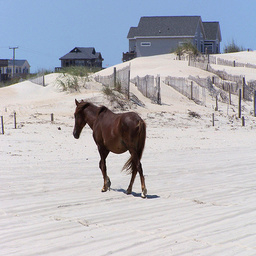

In [10]:
from PIL import Image
X_img = '/home/sh/lab/GAN/paper_review/code/cycle_gan/wandb/latest-run/files/media/images/X_16999_3de4f5bca7909a579120.png'
Image.open(X_img)

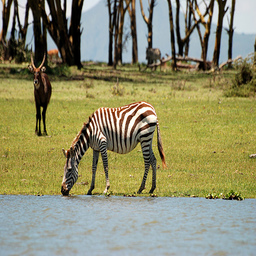

In [11]:
Y_img = '/home/sh/lab/GAN/paper_review/code/cycle_gan/wandb/latest-run/files/media/images/Y_16999_4aa3cbee0f8535d00600.png'
Image.open(Y_img)

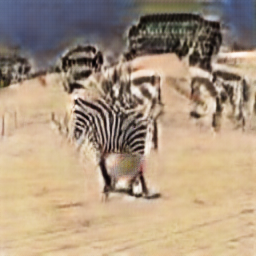

In [12]:
G_x_y = '/home/sh/lab/GAN/paper_review/code/cycle_gan/wandb/latest-run/files/media/images/Generated Target (X->Y)_16999_d5ff5032b80735f62597.png'
Image.open(G_x_y)

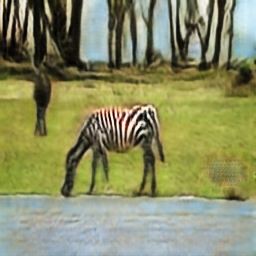

In [13]:
recon = '/home/sh/lab/GAN/paper_review/code/cycle_gan/wandb/latest-run/files/media/images/Reconstructed Target (Y->X->Y)_16999_0390e38e3fb8eff8eaf1.png'
Image.open(recon)

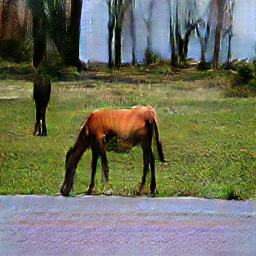

In [15]:
G_input = '/home/sh/lab/GAN/paper_review/code/cycle_gan/wandb/latest-run/files/media/images/Generated Input (Y->X)_16999_2c0d0c12d1fd33ab1785.png'
Image.open(G_input)

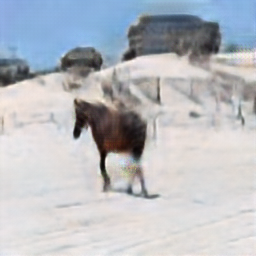

In [16]:
R_input = '/home/sh/lab/GAN/paper_review/code/cycle_gan/wandb/latest-run/files/media/images/Reconstructed Input (X->Y->X)_16999_a69907bcf5cba4667fec.png'
Image.open(R_input)